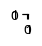

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
from src.cluster_utils import get_latent_df, load_model_full

# inits

In [2]:
exp_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
exp78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
exp17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
old15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

# Debug the return of my iterative cut functions

In [6]:
import networkx as nx
from datetime import datetime as dt
from src.cluster_utils import *
from src.networkx_utils import *

In [13]:
import random
# Take a much smaller subsample to debug because my function is obviously wrong
seed=131
random.seed(seed)
# Take test partition only, subsample
easy5peps = ['ELAGIGILTV', 'GILGFVFTL', 'LLWNGPMAV', 'RAKFKQLL', 'YLQPRTFLL']
testset = exp17.query('peptide in @easy5peps and partition==1')
# Randomly subsample between 60 and 74 datapoints for each peptide:
testset_subsample = []
for p in easy5peps:
    tmp = testset.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(50,70)), random_state=seed))
testset_subsample = pd.concat(testset_subsample)
testset_idx = testset_subsample.query('partition==1')['raw_index'].unique()
testset_subsample.groupby('peptide').count()

,Unnamed: 0.1,Unnamed: 0,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type,db
peptide,,,,,,,,,,,,,,,,,,
ELAGIGILTV,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,10,60,60
GILGFVFTL,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,13,61,61
LLWNGPMAV,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66
RAKFKQLL,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,0,52,52
YLQPRTFLL,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62


In [17]:
# Best model picked on validation performance
model = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                        '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                        map_location='cpu', verbose=False)
latent_df_testset = get_latent_df(model, testset_subsample)
dm_ts128_testset, values_ts128_testset, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_df_testset, index_col='raw_index')

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


In [18]:
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_testset = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0).query('partition==1 and raw_index in @testset_idx')
dm_tcrdist_testset = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0).query('partition==1 and raw_index in @testset_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_testset, values_tbcr_testset = resort_baseline(dm_tbcr_testset, dm_ts128_testset, 'raw_index')
dm_tcrdist_testset, values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, dm_ts128_testset, 'raw_index')

In [77]:
G, tree, dist_matrix, values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128_testset)
tree.edges(data=True)

EdgeDataView([(0, 184, {'weight': 0.34623271226882935}), (0, 34, {'weight': 0.4306254982948303}), (1, 11, {'weight': 0.4081287384033203}), (1, 32, {'weight': 0.6517423391342163}), (2, 267, {'weight': 0.6811701059341431}), (3, 32, {'weight': 0.6503627896308899}), (4, 52, {'weight': 0.6852259039878845}), (5, 152, {'weight': 0.28540563583374023}), (6, 22, {'weight': 0.3681669235229492}), (7, 97, {'weight': 0.6620118021965027}), (8, 51, {'weight': 0.24915474653244019}), (8, 50, {'weight': 0.48686033487319946}), (9, 57, {'weight': 0.37865394353866577}), (9, 158, {'weight': 0.38035815954208374}), (10, 96, {'weight': 0.6821213960647583}), (10, 245, {'weight': 0.7033871412277222}), (11, 45, {'weight': 0.55698561668396}), (12, 34, {'weight': 0.545823335647583}), (12, 53, {'weight': 0.6230318546295166}), (12, 55, {'weight': 0.6314609050750732}), (12, 111, {'weight': 0.7528945207595825}), (13, 79, {'weight': 0.5132654905319214}), (13, 23, {'weight': 0.5228242874145508}), (14, 126, {'weight': 0.49

In [40]:
initial_cut_threshold=1
initial_cut_method='top'
size_tree_cut, size_subgraphs, size_clusters, size_edges_removed, size_nodes_removed, size_scores, size_purities, size_retentions = iterative_size_cut(values, tree, initial_cut_threshold, initial_cut_method, top_n=1, which='edge', 
                                                                                                                                                       weighted=True, verbose=0, max_size=4)
topn_tree_cut, topn_subgraphs, topn_clusters, topn_edges_removed, topn_nodes_removed, topn_scores, topn_purities, topn_retentions = iterative_topn_cut(values, tree, initial_cut_threshold, initial_cut_method, top_n=1, which='edge', 
                                                                                                                                                       weighted=True, verbose=0, score_threshold=.75)

print(len(size_clusters), len(topn_clusters))
print(len(list(nx.connected_components(size_tree_cut))), len(list(nx.connected_components(topn_tree_cut))))


Initial mean purity, silhouette score, retention
0.3555 0.0789 1.0
106 1
2 1


In [41]:
topn_clusters

[{'cluster_size': 2,
  'majority_label': 'LLWNGPMAV',
  'purity': 1.0,
  'counts': {'LLWNGPMAV': 2},
  'members': {139, 143}}]

In [42]:
topn_tree_cut.nodes()

NodeView((139, 143))

In [43]:
topn_tree_cut.edges()

EdgeView([(139, 143)])

## debug topn_cut

In [107]:
G, tree, dist_matrix, values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128_testset)
list(tree.edges(data=True))[:5]

[(0, 184, {'weight': 0.34623271226882935}),
 (0, 34, {'weight': 0.4306254982948303}),
 (1, 11, {'weight': 0.4081287384033203}),
 (1, 32, {'weight': 0.6517423391342163}),
 (2, 267, {'weight': 0.6811701059341431})]

In [123]:
topn_tree_cut, topn_subgraphs, topn_clusters, topn_edges_removed, topn_nodes_removed, topn_scores, topn_purities, topn_retentions = iterative_topn_cut(values, tree, initial_cut_threshold, initial_cut_method, top_n=1, which='edge', 
                                                                                                                                                       weighted=True, verbose=0, score_threshold=.75)

Initial mean purity, silhouette score, retention
0.3555 0.0789 1.0


In [90]:
# initial cut
dist_array=values
weighted=True
verbose=2
which='edge'
top_n=1
tree_cut, clusters, edges_removed, nodes_removed = betweenness_cut(tree, initial_cut_threshold, initial_cut_method,
                                                                   which, False, verbose)
current_silhouette_score = get_silhouette_score_at_cut(dist_array, clusters)
print('Initial mean purity, silhouette score, retention')
print(np.mean([x['purity'] for x in clusters]).round(4), current_silhouette_score, round(sum([x['cluster_size'] for x in clusters])/len(dist_array),4))
iter=-1
# Something is wrong about this. I probably shouldn't loop over every cluster but do a fullgraph cut at each iteration by taking the Top N edges
# TODO : --> Global edge cut
# Can do something about max_silhouette_score to save the "best" trees and clusters
scores = [current_silhouette_score]
purities = [np.mean([x['purity'] for x in clusters])]
retentions = [round(sum([x['cluster_size'] for x in clusters])/len(dist_array),4)]
best_silhouette_score = -1
best_tree, best_clusters, best_edges_removed, best_nodes_removed = tree_cut, clusters, edges_removed, nodes_removed
# Make a copy before starting the iteration to re-use the variable
tree_trimmed = tree_cut.copy()

		edges, nodes
before cutting:	300,	301
after cutting:	299,	301
N components before cutting:	 1
N components after cutting:	 2

Edges removed:
[((107, 204), 0.49563676633444076)]

Nodes removed:
[]
Initial mean purity, silhouette score, retention
0.3445 0.0751 1.0


In [98]:
def get_bet(tree):
    edge_betweenness = nx.edge_betweenness_centrality(tree)
    weighted_edge_betweenness = {k: tree.edges[k]['weight'] * v for k, v in edge_betweenness.items()}
    
    sorted_edges = sorted(edge_betweenness.items(), key=lambda item: item[1], reverse=True)
    sorted_weighted = sorted(weighted_edge_betweenness.items(), key=lambda item: item[1], reverse=True)
    print(sorted_edges[:3])
    print(sorted_weighted[:3])
    return sorted_edges, sorted_weighted

In [125]:
len(topn_subgraphs)

106

In [126]:
len(list(nx.connected_components(topn_tree_cut)))

106

In [127]:
len(topn_clusters)

106

In [101]:
normal, weight = get_bet(tree_trimmed)
normal, weight = get_bet(tree_trimmed_1)

[((94, 204), 0.1542857142857143), ((94, 109), 0.15348837209302327), ((75, 204), 0.15242524916943523)]
[((93, 199), 0.06993362770524136), ((75, 84), 0.06329388522626554), ((93, 118), 0.06298987355343132)]
[((168, 182), 0.09508305647840531), ((182, 184), 0.09056478405315616), ((0, 184), 0.08205980066445183)]
[((0, 34), 0.034793395742625494), ((182, 184), 0.03252628752955567), ((0, 184), 0.02841178735229264)]


In [100]:
# iteration 1 : manual
tree_trimmed_1, clusters_1, edges_trimmed_1, nodes_trimmed_1 = betweenness_cut(tree_trimmed, cut_threshold=top_n, cut_method='top',
                                                                       which=which, weighted=weighted, verbose=verbose)
tree_trimmed_2, clusters_2, edges_trimmed_2, nodes_trimmed_2 = betweenness_cut(tree_trimmed_1, cut_threshold=top_n, cut_method='top',
                                                                       which=which, weighted=weighted, verbose=verbose)

		edges, nodes
before cutting:	299,	301
after cutting:	298,	301
N components before cutting:	 2
N components after cutting:	 3

Edges removed:
[((93, 199), 0.06993362770524136)]

Nodes removed:
[]
		edges, nodes
before cutting:	298,	301
after cutting:	297,	301
N components before cutting:	 3
N components after cutting:	 4

Edges removed:
[((0, 34), 0.034793395742625494)]

Nodes removed:
[]


In [106]:
clusters_2

[{'cluster_size': 99,
  'majority_label': 'GILGFVFTL',
  'purity': 0.3838383838383838,
  'counts': {'ELAGIGILTV': 4,
   'GILGFVFTL': 38,
   'LLWNGPMAV': 14,
   'RAKFKQLL': 21,
   'YLQPRTFLL': 22},
  'members': {18,
   31,
   35,
   58,
   61,
   62,
   63,
   65,
   66,
   67,
   68,
   72,
   73,
   75,
   77,
   78,
   81,
   83,
   84,
   86,
   87,
   88,
   89,
   93,
   94,
   95,
   98,
   99,
   100,
   101,
   102,
   104,
   106,
   108,
   109,
   112,
   113,
   114,
   115,
   116,
   118,
   120,
   122,
   123,
   145,
   150,
   153,
   155,
   157,
   163,
   167,
   171,
   176,
   178,
   180,
   183,
   188,
   193,
   194,
   198,
   203,
   204,
   208,
   209,
   211,
   214,
   215,
   216,
   217,
   219,
   220,
   227,
   228,
   229,
   230,
   232,
   233,
   243,
   244,
   250,
   252,
   254,
   260,
   264,
   265,
   272,
   273,
   274,
   275,
   277,
   286,
   287,
   290,
   291,
   292,
   293,
   295,
   297,
   299}},
 {'cluster_size': 96,
  'm

In [104]:
len(clusters_1)

3